# Sampling in the Rashomon Set for Fairness

In [ ]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean


# Supress warnings
import warnings; warnings.simplefilter('ignore')

### Preparing data

In [2]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [3]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') 

# Loading Adult
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num', 'race', 'income']), 1, inplace=True)

# droping all races but white and black
adult_dataset['race'] = adult_dataset['race'].replace('Amer-Indian-Eskimo',np.nan)
adult_dataset['race'] = adult_dataset['race'].replace('Asian-Pac-Islander',np.nan)
adult_dataset['race'] = adult_dataset['race'].replace('Other',np.nan)
adult_dataset.dropna(how='any',inplace=True)

#get income
income_raw = deepcopy(adult_dataset['income'])
income_raw.replace(['<=50K', '>50K'],[0, 1], inplace=True)
adult_dataset = adult_dataset.drop(['income'], axis=1)
#income = pd.Series(income_raw).astype('category').cat.codes#.tolist()

# replacing values
adult_dataset['race'].replace(['Black', 'White'],[0, 1], inplace=True)

In [4]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(adult_dataset, income_raw, test_size = 0.5, random_state = 0)

### Implementing my own ridge regression

In [5]:
def get_ridge(X, Y, alpha):
    return np.linalg.inv(X.T@X + alpha*np.identity(X.shape[1])) @ X.T @ Y

def get_ridge_prediction(parameter, X):
    return X@parameter

def get_ridge_l2_loss(parameter, alpha, X, Y):
    fp = Y - X@parameter
    n = X.shape[0]
    return (np.dot(fp, fp) + alpha * np.dot(parameter, parameter))

### Sampling from Rashomon set

In [6]:
def samp_in_hull(points, n):
    dims = points.shape[-1] #get dim
    hull = points[ConvexHull(points).vertices] #get hull
    deln = hull[Delaunay(hull).simplices] #get Delunay

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum()) 

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

### Choosing the best model parameter

In [7]:
# Defining parameter for Ridge regression
alpha = 1

In [8]:
np_X = X_train.to_numpy()
omega_hat = get_ridge(np_X, Y_train, alpha)

### Finding Rashomon set

In [9]:
center = omega_hat
delta = 0.0001 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 300 #number of directions
epsilon = 1*10**(-1) #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 68.83it/s]


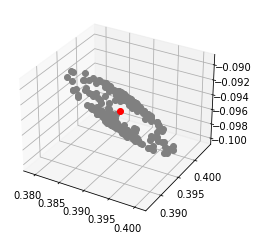

In [10]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(extremes_l[:, 0], extremes_l[:, 1], extremes_l[:, 2],'o', color = 'gray')
ax.plot3D(center[0], center[1], center[2], 'o', color='red');
plt.show()

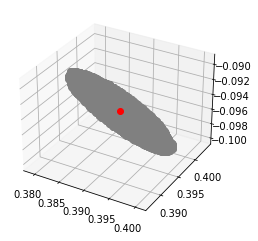

In [53]:
samples = 20000
parameters = samp_in_hull(extremes_l, samples)

# Data for a three-dimensionalThis 
ax = plt.axes(projection='3d')
ax.plot3D(parameters[:, 0], parameters[:, 1],parameters[:, 2] , 'o', color='gray')
ax.plot3D(center[0], center[1], center[2], 'o', color='red');
plt.show()

# Getting fairest model

In [54]:
def fairness_score(parameter, X, Y):
    
    white_X = X[X['race'] == 1]
    white_Y = Y[X['race'] == 1]
    
    black_X = X[X['race'] == 0]
    black_Y = Y[X['race'] == 0]
    
    MSE_white = np.mean(np.square(white_X @ parameter - white_Y))
    MSE_black = np.mean(np.square(black_X @ parameter - black_Y))
        
    return np.abs(MSE_black - MSE_white)

In [56]:
fairest_par = center
fair_score = fairness_score(center, X_train, Y_train)
parameters
for i in tqdm(range(samples)):
    if fairness_score(parameters[i], X_train, Y_train) < fair_score:
        fairest_par = parameters[i]
        fair_score = fairness_score(parameters[i], X_train, Y_train)

100%|████████████████████████████████████| 20000/20000 [00:41<00:00, 479.05it/s]


In [57]:
print('The fairest parameter is:' + str(fairest_par) + ' and have fair score = ' + str(fair_score))
print('The loss minimizer is:' + str(center) + ' and have fair score = ' + str(fairness_score(center, X_train, Y_train)))


The fairest parameter is:[ 0.39239415  0.40325199 -0.10021761] and have fair score = 0.02223483769518078
The loss minimizer is:[ 0.38970068  0.39590811 -0.09474173] and have fair score = 0.024537457148942704


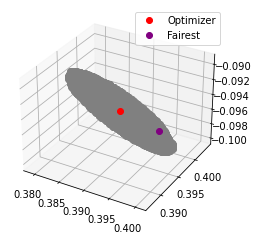

In [63]:
# Data for a three-dimensional
ax = plt.axes(projection='3d')
ax.plot3D(parameters[:, 0], parameters[:, 1],parameters[:, 2] , 'o', color='gray')
ax.plot3D(center[0], center[1], center[2], 'o', color='red', label = 'Optimizer');
ax.plot3D(fairest_par[0], fairest_par[1], fairest_par[2], 'o', color='purple', label = 'Fairest');
plt.legend()
plt.show()